<a href="https://colab.research.google.com/github/LordFunghi/imageGenerator/blob/main/flux.1-schnell_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.28.post2
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/black-forest-labs/FLUX.1-schnell/resolve/main/flux1-schnell.safetensors -d /content/TotoroUI/models/unet -o flux1-schnell.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-schnell.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 14652, done.
remote: Counting objects: 100% (2803/2803), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 14652 (delta 2708), reused 2622 (delta 2622), pack-reused 11849 (from 1)
Receiving objects: 100% (14652/14652), 22.90 MiB | 7.06 MiB/s, done.
Resolving deltas: 100% (9900/9900), done.
/content/TotoroUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 865.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Seed: 7453014440518340090
Noise Object: <totoro_extras.nodes_custom_sampler.Noise_RandomNoise object at 0x7b0f34f865c0>
latent_image_result: ({'samples': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.

  0%|          | 0/4 [00:00<?, ?it/s]

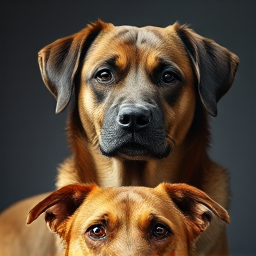

In [21]:
with torch.inference_mode():
    positive_prompt = (
        "A realistic image of a dog in the center of the image. "
        "Another dog partially overlapping the first one at the bottom of the image. "
        "Highly detailed, realistic, sharp."
    )
    width = 256
    height = 256
    seed = 0
    steps = 4
    sampler_name = "euler"
    scheduler = "simple"

    # Generate a random seed if seed is set to 0
    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(f"Seed: {seed}")

    # Encode the positive prompt
    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]

    # Generate random noise based on the seed
    noise_object = RandomNoise.get_noise(seed)[0]  # noise_object is likely a Noise_RandomNoise object

    # Inspect the noise_object to understand its structure
    print(f"Noise Object: {noise_object}")

    # Generate an empty latent image
    latent_image_result = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))
    print(f"latent_image_result: {latent_image_result}")  # Debug step to inspect structure

    # Extract the latent tensor from the tuple (accessing the 'samples' key in the dictionary)
    latent_image = latent_image_result[0]["samples"]
    print(f"Latent Image Shape: {latent_image.shape}")  # Debug step to verify tensor shape

    # Wrap the tensor in a dictionary with 'samples' key, as generate_noise expects this structure
    input_latent = {"samples": latent_image}

    # Call generate_noise method with the input_latent
    try:
        noise = noise_object.generate_noise(input_latent=input_latent)  # Pass latent_image wrapped in dictionary
        print(f"Noise Shape: {noise.shape}")  # Debug step to verify tensor shape
    except TypeError:
        print("Error: Unable to generate noise using input_latent.")
        noise = None

    # If noise is None, investigate further
    if noise is None:
        raise ValueError("Unable to extract noise tensor from the Noise_RandomNoise object.")

    # Set up the guider, sampler, and scheduler
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]

    # Create a spatial mask to bias the generation
    def create_spatial_mask(latent_tensor):
        # Assuming latent_tensor is now a tensor or numpy array
        latent_height, latent_width = latent_tensor.shape[-2:]  # Extract spatial dimensions

        # Create a mask with the same spatial dimensions as the latent tensor
        mask = np.zeros((latent_height, latent_width), dtype=np.float32)

        # Calculate the regions for center and bottom dogs
        center_y, center_x = latent_height // 2, latent_width // 2

        # Center dog region (16x16 block at the center of the latent space)
        mask[center_y - 16:center_y + 16, center_x - 16:center_x + 16] = 1.0

        # Bottom dog region (32 pixels at the bottom, spanning width)
        bottom_start = latent_height - 32
        mask[bottom_start:latent_height, :] = 1.0

        # Convert to tensor and expand to match latent_tensor dimensions if needed
        return torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add batch/channel dimension

    # Generate the spatial mask
    mask = create_spatial_mask(latent_image)

    # Apply the mask to guide the noise
    noise_masked = noise * mask  # Apply the mask

    # Now wrap the latent image as a dictionary for the sample method
    latent_image_dict = {"samples": latent_image}

    # Call the sampler and generate the sample
    try:
        # Pass the correct noise object (not just the tensor) to the sampler
        sample, sample_denoised = SamplerCustomAdvanced.sample(noise_object, guider, sampler, sigmas, latent_image_dict)
    except Exception as e:
        print(f"Error during sampling: {e}")
        sample = None

    # Free memory
    model_management.soft_empty_cache()

    # Decode the final latent image to pixel space
    decoded = VAEDecode.decode(vae, sample)[0].detach()

    # Save the final image
    Image.fromarray(np.array(decoded * 255, dtype=np.uint8)[0]).save("/content/flux.png")

# Display the final image in the notebook
Image.fromarray(np.array(decoded * 255, dtype=np.uint8)[0])
